# NEURAL NETWORKS AND DEEP LEARNING <br> PHYSICS OF DATA - Department of Physics and Astronomy  <br>  A.A. 2019/20 (6 CFU) <br> Student: Matteo Guida


In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import random, pickle
import AEs 
from copy import deepcopy

from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from tqdm import trange, tqdm
from torchvision.datasets import MNIST
from tqdm import tqdm
from importlib import reload
reload(AEs)
import AEs 


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## DASET

In [3]:
data_dir = '.\MNIST_datasets'

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset0 = MNIST(data_dir, train=True,  download=False, transform=train_transform)
test_dataset  = MNIST(data_dir, train=False, download=False, transform=test_transform)

join_train_dataloader = DataLoader(train_dataset0,batch_size=512,shuffle=True)

torch.manual_seed(int(1996))
train_dim = int(len(train_dataset0)*0.8)
val_dim = len(train_dataset0)-train_dim
train_dataset1, val_dataset1 = torch.utils.data.random_split(train_dataset0, [train_dim, val_dim])

print('DATASET PARTITIONS: \n')
print('Size of the training set:',len(train_dataset1))
print('Size of the validation set:',len(val_dataset1))
print('Size of the test set:',len(test_dataset))


train_dataloader = DataLoader(train_dataset1, batch_size=512, shuffle=True)
val_dataloader   = DataLoader(val_dataset1,   batch_size=512, shuffle=False)
test_dataloader  = DataLoader(test_dataset,  batch_size=512, shuffle=False)

DATASET PARTITIONS: 

Size of the training set: 48000
Size of the validation set: 12000
Size of the test set: 10000


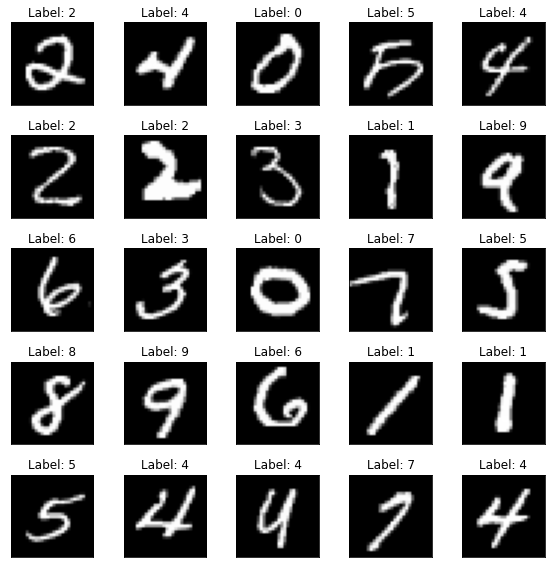

In [4]:
### Plot some sample
plt.close('all')
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(train_dataset0)
    ax.imshow(img.squeeze().numpy(), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## RANDOM SEARCH

In [7]:
encode_dim =4
params_dict = {
           "lr" : [-4,-2],
           "penalty" : [-4,-3],
           "optimizer" : ['torch.optim.Adam', 'torch.optim.Adamax',"torch.optim.AdamW"],
           "dropout" : [0.1,0.4],          
           "ncombinations" : [30],
           "n_epochs" : [60,100]
           }

In [8]:
list_single_dict = AEs.get_list_rand_search(params_dict)
print("The first 4 combinations as example: \n")
print(list_single_dict[:4])

The first 4 combinations as example: 

[['torch.optim.Adamax', 0.1953321183707512, 0.0001144208482519295, 0.0005541355828122471, 96], ['torch.optim.AdamW', 0.18122567131541195, 0.00014924296184417048, 0.0004912621721593351, 75], ['torch.optim.AdamW', 0.24378830794907239, 0.0002417036349104561, 0.0009280942468067208, 91], ['torch.optim.Adam', 0.11381086037655572, 0.0004053811360509158, 0.00011033105275256643, 70]]


In [6]:
list_val_error = []
list_dict = []
for i in trange(params_dict["ncombinations"][0]):
    single_dict= {
               "optimizer" : [list_single_dict[i][0]],
               "dropout" : [list_single_dict[i][1]],
               "lr" : [list_single_dict[i][2]],
               "penalty" : [list_single_dict[i][3]],
               "n_epochs" : [list_single_dict[i][4]]
               }
    print("single_dict",single_dict)
    
    
    ### Init
    net = AEs.Autoencoder(encoded_space_dim=encode_dim,params_dict = single_dict).to(device)
    train_loss, val_loss = net.trainin(train_dataloader=train_dataloader,test_dataloader=val_dataloader,
                                        params_dict = single_dict,verbose = False,return_log=False)

    print("__________________________")
    print("TRAINING LOSS",round(float(train_loss),3))
    print("VALIDATION LOSS",round(float(val_loss.numpy()),3))
    print("__________________________")
    list_val_error.append(val_loss)
    list_dict.append(single_dict)

ordered_list = list(zip(*sorted(zip(list_val_error, list_dict))))

with open('./results/train_results_fixed_hidden.data', 'wb') as filehandle:
    pickle.dump(ordered_list, filehandle)

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

single_dict {'optimizer': ['torch.optim.Adam'], 'dropout': [0.2981830088316144], 'lr': [0.00012386191423537633], 'penalty': [0.000605131809177908], 'n_epochs': [82]}


  3%|██▋                                                                             | 1/30 [14:51<7:10:48, 891.33s/it]

__________________________
TRAINING LOSS 0.067
VALIDATION LOSS 0.065
__________________________
single_dict {'optimizer': ['torch.optim.AdamW'], 'dropout': [0.30361899658130287], 'lr': [0.00011204602322291578], 'penalty': [0.00034758868623957435], 'n_epochs': [98]}


  7%|█████▎                                                                          | 2/30 [32:28<7:19:11, 941.13s/it]

__________________________
TRAINING LOSS 0.047
VALIDATION LOSS 0.039
__________________________
single_dict {'optimizer': ['torch.optim.Adamax'], 'dropout': [0.17480629819370377], 'lr': [0.0003744795319532273], 'penalty': [0.00013627337220677543], 'n_epochs': [91]}


 10%|████████                                                                        | 3/30 [48:52<7:09:14, 953.86s/it]

__________________________
TRAINING LOSS 0.055
VALIDATION LOSS 0.052
__________________________
single_dict {'optimizer': ['torch.optim.AdamW'], 'dropout': [0.35562654063149], 'lr': [0.000100254230976268], 'penalty': [0.00016844150877432475], 'n_epochs': [85]}


 13%|██████████▍                                                                   | 4/30 [1:04:11<6:48:47, 943.37s/it]

__________________________
TRAINING LOSS 0.052
VALIDATION LOSS 0.044
__________________________
single_dict {'optimizer': ['torch.optim.AdamW'], 'dropout': [0.10103719431422302], 'lr': [0.004930800128791532], 'penalty': [0.00041474931564672914], 'n_epochs': [72]}


 17%|█████████████                                                                 | 5/30 [1:17:10<6:12:33, 894.14s/it]

__________________________
TRAINING LOSS 0.035
VALIDATION LOSS 0.03
__________________________
single_dict {'optimizer': ['torch.optim.AdamW'], 'dropout': [0.3670818956352174], 'lr': [0.0002937985052871436], 'penalty': [0.00019256326760480147], 'n_epochs': [86]}


 20%|███████████████▌                                                              | 6/30 [1:32:54<6:03:36, 909.01s/it]

__________________________
TRAINING LOSS 0.048
VALIDATION LOSS 0.04
__________________________
single_dict {'optimizer': ['torch.optim.AdamW'], 'dropout': [0.3149374077006418], 'lr': [0.009859147296610277], 'penalty': [0.00014216898971982096], 'n_epochs': [89]}


 23%|██████████████████▏                                                           | 7/30 [1:48:58<5:54:49, 925.63s/it]

__________________________
TRAINING LOSS 0.049
VALIDATION LOSS 0.041
__________________________
single_dict {'optimizer': ['torch.optim.Adam'], 'dropout': [0.2573516317546958], 'lr': [0.005883871938176889], 'penalty': [0.00021235317033800326], 'n_epochs': [95]}


 27%|████████████████████▊                                                         | 8/30 [2:06:16<5:51:45, 959.36s/it]

__________________________
TRAINING LOSS 0.064
VALIDATION LOSS 0.062
__________________________
single_dict {'optimizer': ['torch.optim.AdamW'], 'dropout': [0.2682542971497316], 'lr': [0.00010323463456613955], 'penalty': [0.0009802343362842584], 'n_epochs': [85]}


 30%|███████████████████████▍                                                      | 9/30 [2:21:36<5:31:40, 947.63s/it]

__________________________
TRAINING LOSS 0.047
VALIDATION LOSS 0.041
__________________________
single_dict {'optimizer': ['torch.optim.Adam'], 'dropout': [0.31364038670138095], 'lr': [0.0003256776751232527], 'penalty': [0.00017993935253080744], 'n_epochs': [85]}


 33%|█████████████████████████▋                                                   | 10/30 [2:36:53<5:12:49, 938.46s/it]

__________________________
TRAINING LOSS 0.055
VALIDATION LOSS 0.049
__________________________
single_dict {'optimizer': ['torch.optim.Adamax'], 'dropout': [0.11955298176261167], 'lr': [0.000843239570703795], 'penalty': [0.0009559277055423055], 'n_epochs': [72]}


 37%|████████████████████████████▏                                                | 11/30 [2:50:06<4:43:19, 894.70s/it]

__________________________
TRAINING LOSS 0.066
VALIDATION LOSS 0.065
__________________________
single_dict {'optimizer': ['torch.optim.Adam'], 'dropout': [0.20760573023082174], 'lr': [0.00010202002924376648], 'penalty': [0.0007161888612436071], 'n_epochs': [68]}


 40%|██████████████████████████████▊                                              | 12/30 [3:02:22<4:14:10, 847.24s/it]

__________________________
TRAINING LOSS 0.066
VALIDATION LOSS 0.064
__________________________
single_dict {'optimizer': ['torch.optim.Adamax'], 'dropout': [0.1885042384474403], 'lr': [0.008339108272591617], 'penalty': [0.00012866641740442417], 'n_epochs': [77]}


 43%|█████████████████████████████████▎                                           | 13/30 [3:16:17<3:59:00, 843.56s/it]

__________________________
TRAINING LOSS 0.043
VALIDATION LOSS 0.037
__________________________
single_dict {'optimizer': ['torch.optim.Adam'], 'dropout': [0.19153691053871463], 'lr': [0.0066548385432660655], 'penalty': [0.00033304176812281574], 'n_epochs': [64]}


 47%|███████████████████████████████████▉                                         | 14/30 [3:27:50<3:32:52, 798.26s/it]

__________________________
TRAINING LOSS 0.064
VALIDATION LOSS 0.063
__________________________
single_dict {'optimizer': ['torch.optim.Adamax'], 'dropout': [0.17440735371815633], 'lr': [0.0029369075928533644], 'penalty': [0.00012687760999867355], 'n_epochs': [65]}


 50%|██████████████████████████████████████▌                                      | 15/30 [3:39:35<3:12:36, 770.42s/it]

__________________________
TRAINING LOSS 0.042
VALIDATION LOSS 0.036
__________________________
single_dict {'optimizer': ['torch.optim.AdamW'], 'dropout': [0.2911871521319951], 'lr': [0.007895281353539363], 'penalty': [0.0001719475701851874], 'n_epochs': [84]}


 53%|█████████████████████████████████████████                                    | 16/30 [3:55:10<3:11:14, 819.63s/it]

__________________________
TRAINING LOSS 0.068
VALIDATION LOSS 0.068
__________________________
single_dict {'optimizer': ['torch.optim.Adam'], 'dropout': [0.34431409965663745], 'lr': [0.0003895927505580394], 'penalty': [0.00010672067736560199], 'n_epochs': [69]}


 57%|███████████████████████████████████████████▋                                 | 17/30 [4:07:53<2:53:56, 802.82s/it]

__________________________
TRAINING LOSS 0.05
VALIDATION LOSS 0.042
__________________________
single_dict {'optimizer': ['torch.optim.Adam'], 'dropout': [0.3448724755272696], 'lr': [0.0032697960114176786], 'penalty': [0.0008661360411904766], 'n_epochs': [89]}


 60%|██████████████████████████████████████████████▏                              | 18/30 [4:24:16<2:51:22, 856.84s/it]

__________________________
TRAINING LOSS 0.069
VALIDATION LOSS 0.068
__________________________
single_dict {'optimizer': ['torch.optim.Adamax'], 'dropout': [0.11633168138044371], 'lr': [0.00085600573182029], 'penalty': [0.00016783551030779905], 'n_epochs': [63]}


 63%|████████████████████████████████████████████████▊                            | 19/30 [4:35:53<2:28:17, 808.84s/it]

__________________________
TRAINING LOSS 0.051
VALIDATION LOSS 0.048
__________________________
single_dict {'optimizer': ['torch.optim.AdamW'], 'dropout': [0.16834406589548215], 'lr': [0.005484719271165072], 'penalty': [0.00047823328965512996], 'n_epochs': [81]}


 67%|███████████████████████████████████████████████████▎                         | 20/30 [4:51:25<2:20:56, 845.62s/it]

__________________________
TRAINING LOSS 0.04
VALIDATION LOSS 0.033
__________________________
single_dict {'optimizer': ['torch.optim.AdamW'], 'dropout': [0.282439129181592], 'lr': [0.00016879052130075326], 'penalty': [0.0002421727438269535], 'n_epochs': [76]}


 70%|█████████████████████████████████████████████████████▉                       | 21/30 [5:06:46<2:10:15, 868.40s/it]

__________________________
TRAINING LOSS 0.047
VALIDATION LOSS 0.04
__________________________
single_dict {'optimizer': ['torch.optim.Adam'], 'dropout': [0.16183392852446427], 'lr': [0.00036680200158058067], 'penalty': [0.0009615714084140521], 'n_epochs': [79]}


 73%|████████████████████████████████████████████████████████▍                    | 22/30 [5:21:31<1:56:25, 873.20s/it]

__________________________
TRAINING LOSS 0.067
VALIDATION LOSS 0.066
__________________________
single_dict {'optimizer': ['torch.optim.Adam'], 'dropout': [0.2895396819808043], 'lr': [0.0006616386029133529], 'penalty': [0.0003003337643708015], 'n_epochs': [77]}


 77%|███████████████████████████████████████████████████████████                  | 23/30 [5:36:02<1:41:47, 872.53s/it]

__________________________
TRAINING LOSS 0.064
VALIDATION LOSS 0.062
__________________________
single_dict {'optimizer': ['torch.optim.Adamax'], 'dropout': [0.399067476663035], 'lr': [0.00029762088417005197], 'penalty': [0.0005409322135012495], 'n_epochs': [75]}


 80%|█████████████████████████████████████████████████████████████▌               | 24/30 [5:50:28<1:27:03, 870.64s/it]

__________________________
TRAINING LOSS 0.067
VALIDATION LOSS 0.065
__________________________
single_dict {'optimizer': ['torch.optim.Adam'], 'dropout': [0.12999250670559076], 'lr': [0.004362655606669596], 'penalty': [0.000283642212930101], 'n_epochs': [93]}


 83%|████████████████████████████████████████████████████████████████▏            | 25/30 [6:08:58<1:18:32, 942.51s/it]

__________________________
TRAINING LOSS 0.063
VALIDATION LOSS 0.061
__________________________
single_dict {'optimizer': ['torch.optim.Adamax'], 'dropout': [0.24663796294234974], 'lr': [0.0002311542463624082], 'penalty': [0.0007133931439442509], 'n_epochs': [75]}


 87%|██████████████████████████████████████████████████████████████████▋          | 26/30 [6:24:11<1:02:14, 933.52s/it]

__________________________
TRAINING LOSS 0.066
VALIDATION LOSS 0.065
__________________________
single_dict {'optimizer': ['torch.optim.AdamW'], 'dropout': [0.13035417652547873], 'lr': [0.007446400227811285], 'penalty': [0.0004220316014963389], 'n_epochs': [95]}


 90%|███████████████████████████████████████████████████████████████████████        | 27/30 [6:43:08<49:44, 994.69s/it]

__________________________
TRAINING LOSS 0.037
VALIDATION LOSS 0.031
__________________________
single_dict {'optimizer': ['torch.optim.AdamW'], 'dropout': [0.14819549909666424], 'lr': [0.00017384300738082856], 'penalty': [0.00041347678324097243], 'n_epochs': [88]}


 93%|████████████████████████████████████████████████████████████████████████▊     | 28/30 [7:00:26<33:35, 1007.61s/it]

__________________________
TRAINING LOSS 0.039
VALIDATION LOSS 0.033
__________________________
single_dict {'optimizer': ['torch.optim.Adam'], 'dropout': [0.12366011790752104], 'lr': [0.0004196344543093782], 'penalty': [0.00025202771596459256], 'n_epochs': [90]}


 97%|███████████████████████████████████████████████████████████████████████████▍  | 29/30 [7:18:13<17:05, 1025.52s/it]

__________________________
TRAINING LOSS 0.062
VALIDATION LOSS 0.061
__________________________
single_dict {'optimizer': ['torch.optim.AdamW'], 'dropout': [0.2206597869697319], 'lr': [0.0018655697266426491], 'penalty': [0.00011436947156124958], 'n_epochs': [70]}


100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [7:31:42<00:00, 903.42s/it]

__________________________
TRAINING LOSS 0.04
VALIDATION LOSS 0.033
__________________________


In [10]:
# Load the rankings made with the train. 
with open('./results/train_results_fixed_hidden.data', "rb") as input_file:
    load_results = pickle.load(input_file)
load_results = list(zip(*load_results))
best_combination = load_results[0][1]
print("VALIDATION ERROR BEST HP:", round(float(load_results[0][0].numpy()),3))
print("")
print("BEST FOUND HP CLASS: \n",best_combination)

VALIDATION ERROR BEST HP: 0.03

BEST FOUND HP CLASS: 
 {'optimizer': ['torch.optim.AdamW'], 'dropout': [0.10103719431422302], 'lr': [0.004930800128791532], 'penalty': [0.00041474931564672914], 'n_epochs': [72]}


In [11]:
# Iterate again the best ipothesis class on train+validation sets.

best_net = AEs.Autoencoder(encoded_space_dim=encode_dim,params_dict = best_combination).to(device)
train_loss_log,test_loss_log,train_loss,test_loss = best_net.trainin(train_dataloader=join_train_dataloader,test_dataloader=test_dataloader,
                                        params_dict = best_combination,verbose = True,return_log=True)
print("TEST LOSS BEST HP:", round(float(test_loss.numpy()),3))



EPOCH 1
TRAINING LOSS 0.082
VALIDATION LOSS 0.064


EPOCH 2
TRAINING LOSS 0.06
VALIDATION LOSS 0.048


EPOCH 3
TRAINING LOSS 0.048
VALIDATION LOSS 0.04


EPOCH 4
TRAINING LOSS 0.044
VALIDATION LOSS 0.037


EPOCH 5
TRAINING LOSS 0.042
VALIDATION LOSS 0.036


EPOCH 6
TRAINING LOSS 0.041
VALIDATION LOSS 0.035


EPOCH 7
TRAINING LOSS 0.04
VALIDATION LOSS 0.034


EPOCH 8
TRAINING LOSS 0.04
VALIDATION LOSS 0.034


EPOCH 9
TRAINING LOSS 0.039
VALIDATION LOSS 0.033


EPOCH 10
TRAINING LOSS 0.039
VALIDATION LOSS 0.033


EPOCH 11
TRAINING LOSS 0.039
VALIDATION LOSS 0.033


EPOCH 12
TRAINING LOSS 0.038
VALIDATION LOSS 0.033


EPOCH 13
TRAINING LOSS 0.038
VALIDATION LOSS 0.032


EPOCH 14
TRAINING LOSS 0.038
VALIDATION LOSS 0.032


EPOCH 15
TRAINING LOSS 0.038
VALIDATION LOSS 0.032


EPOCH 16
TRAINING LOSS 0.038
VALIDATION LOSS 0.032


EPOCH 17
TRAINING LOSS 0.038
VALIDATION LOSS 0.032


EPOCH 18
TRAINING LOSS 0.038
VALIDATION LOSS 0.032


EPOCH 19
TRAINING LOSS 0.037
VALIDATION LOSS 0.032


EPOC

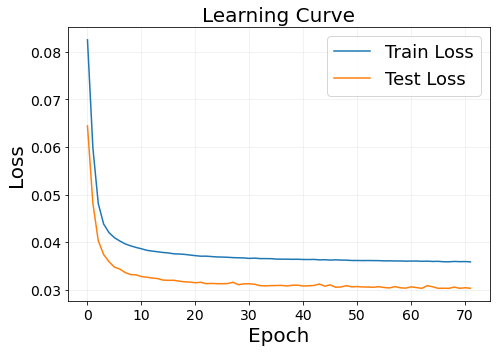

In [14]:
fig = plt.figure()
plt.plot(train_loss_log, label='Train Loss')
plt.plot(test_loss_log, label='Test Loss')
plt.title('Learning Curve',fontsize=20)
plt.xlabel("Epoch",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.tick_params(labelsize=14)
fig.set_size_inches(7, 5)
plt.grid(alpha=0.2)
plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig('./plots/learning_curve.png',bbox_inches="tight")
plt.show()


## SIZE OF THE HIDDEN LAYER STUDY

In [18]:
encode_space_dim_list = np.arange(2,22,step=2)
val_loss_list_hidden = []


for encode_dim in tqdm(encode_space_dim_list):

    net_hidden_study = AEs.Autoencoder(encoded_space_dim=encode_dim,params_dict = best_combination).to(device)    
    train_loss_log,val_loss_log,train_loss,val_loss = net_hidden_study.trainin(train_dataloader=train_dataloader, 
                                            test_dataloader=val_dataloader,params_dict=best_combination,verbose = False,return_log=True)
    val_loss_list_hidden.append(val_loss)

ordered_list_hidden = list(zip(val_loss_list_hidden, encode_space_dim_list))

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:59:20<00:00, 716.00s/it]


In [24]:
with open('./results/train_results_selected_hidden.data', 'wb') as filehandle:
    pickle.dump(ordered_list_hidden, filehandle)

In [5]:
with open('./results/train_results_selected_hidden.data', "rb") as input_file:
    load_results_hidden = pickle.load(input_file)

In [6]:
val_loss_hidden = [load_results_hidden[i][0] for i in range(len(load_results_hidden))]
size_hidden = [load_results_hidden[i][1] for i in range(len(load_results_hidden))]

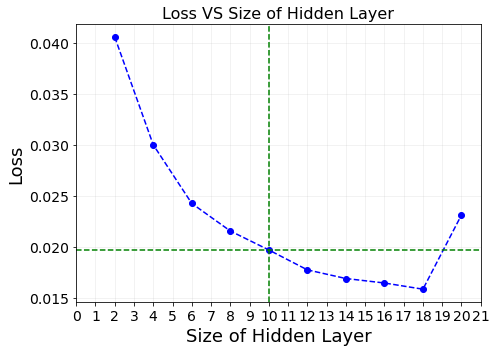

In [7]:
fig = plt.figure()
plt.plot(size_hidden,val_loss_hidden, label='Validation Loss',linestyle='--', marker='o', color='b')
plt.title('Loss VS Size of Hidden Layer',fontsize=16)
plt.ylabel("Loss",fontsize=18)
plt.xlabel("Size of Hidden Layer",fontsize=18)
plt.tick_params(labelsize=14)
fig.set_size_inches(7, 5)
plt.grid(alpha=0.2)
plt.xticks(range(0,22))
plt.axhline(y=val_loss_hidden[4], color='g', linestyle='--')
plt.axvline(x=size_hidden[4], color='g', linestyle='--')
plt.tight_layout()
plt.savefig('./plots/loss_vs_size_of_hidden_layer1.png',bbox_inches="tight")
plt.show()

In [31]:
best_net_fixed_hidden = AEs.Autoencoder(encoded_space_dim=load_results_hidden[4][1],params_dict = best_combination).to(device)
train_loss_log,test_loss_log,train_loss,test_loss = best_net_fixed_hidden.trainin(train_dataloader=join_train_dataloader,test_dataloader=test_dataloader,
                                        params_dict = best_combination,verbose = False,return_log=True)

torch.save(best_net_fixed_hidden, './models/best_network.dat')
torch.save(best_net_fixed_hidden.state_dict(), './models/best_net_fixed_hidden.pth')

In [32]:
print("TEST LOSS BEST FOUND HP WITH SELECTED HIDDEN LAYER = "+str(load_results[4][1])+" ON ORIGINAL TEST SET:", round(float(test_loss.numpy()),3))

TEST LOSS BEST FOUND HP WITH SELECTED HIDDEN LAYER = {'optimizer': ['torch.optim.AdamW'], 'dropout': [0.2206597869697319], 'lr': [0.0018655697266426491], 'penalty': [0.00011436947156124958], 'n_epochs': [70]} ON ORIGINAL TEST SET: 0.018


## TEST SET CORRUPTION WITH GAUSSIAN NOISE AND OCCLUSION

In [ ]:
def MNIST_occlusion(dataset,square_lenght=10):
    temp_dataset = deepcopy(dataset)
    side_image = 28
    
    percentage = (square_lenght**2)/(28**2)*100
    randint= np.random.randint(low=0, high=side_image-square_lenght)
    temp_dataset.data[:,randint:randint+square_lenght, randint:randint+square_lenght]=0
    return temp_dataset, percentage

### GAUSSIAN NOISE

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,6))
gaussian_test_transform = transforms.Compose([
transforms.ToTensor(),
transforms.Lambda(lambda x: (x+np.random.normal(scale=sigma,size=x.shape)).float()),
])

for i,sigma in enumerate([0.1,0.5,0.9]):
    np.random.seed(1996)
    noised_test_dataset = MNIST(data_dir, train=False, download=False, transform=gaussian_test_transform)
    noised_test_dataloader = DataLoader(noised_test_dataset, batch_size=512, shuffle=False)
    
    ax[i].imshow(next(iter(noised_test_dataloader))[0][0].squeeze().cpu().numpy(), cmap='Greys') 
    ax[i].set_title('Element of \n MNIST Dataset $\sigma =$'+str(sigma),fontsize=24)
    ax[i].tick_params(labelsize=20)

plt.savefig('./plots/mnist_noised.png',bbox_inches="tight")

plt.show()    

In [ ]:
std_noise_list = np.arange(0.1,0.9,step=0.1)
test_loss_noise_list = []
for sigma in std_noise_list:
    best_net_dae_load = AEs.Autoencoder(encoded_space_dim=load_results_hidden[4][1],params_dict = best_combination).to(device)
    best_net_dae_load.load_state_dict(torch.load('./models/best_net_fixed_hidden.pth', map_location=device))
    best_net_dae_load.to(device);
    np.random.seed(1996)
    noised_test_dataset = MNIST(data_dir, train=False, download=False, transform=gaussian_test_transform)
    noised_test_dataloader = DataLoader(noised_test_dataset, batch_size=512, shuffle=False)
    test_loss_noise = best_net_dae_load.test_epoch(noised_test_dataloader)
    print("TEST LOSS BEST HP ON TEST SET WITH NOISE σ = "+ str(round(sigma,1)) +" :", round(float(test_loss_noise),4))
    test_loss_noise_list.append(float(test_loss_noise))
    ordered_list_noise = list(zip(test_loss_noise_list, std_noise_list))

In [77]:
with open('./results/train_results_noise.data', 'wb') as filehandle_noise:
    pickle.dump(ordered_list_noise, filehandle_noise)

In [78]:
with open('./results/train_results_noise.data', "rb") as input_file_noise:
    load_results_noise = pickle.load(input_file_noise)

In [79]:
test_loss_noise = [load_results_noise[i][0] for i in range(len(load_results_noise))]
sigma_noise = [load_results_noise[i][1] for i in range(len(load_results_noise))]

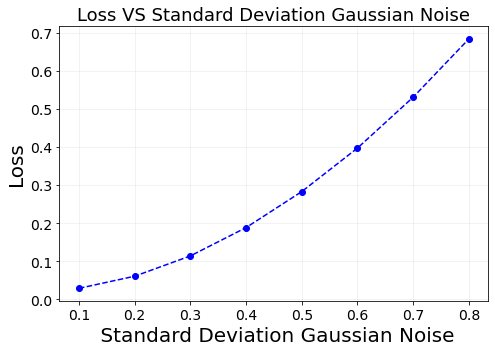

In [92]:
fig = plt.figure()
plt.plot(sigma_noise,test_loss_noise, label='Validation Loss',linestyle='--', marker='o', color='b')
plt.title('Loss VS Standard Deviation Gaussian Noise',fontsize=18)
plt.ylabel("Loss",fontsize=20)
plt.xlabel(" Standard Deviation Gaussian Noise",fontsize=20)
plt.tick_params(labelsize=14)
fig.set_size_inches(7, 5)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig('./plots/loss_vs_standard_deviation_gaussian_noise.png',bbox_inches="tight")
plt.show()

### OCCLUSION

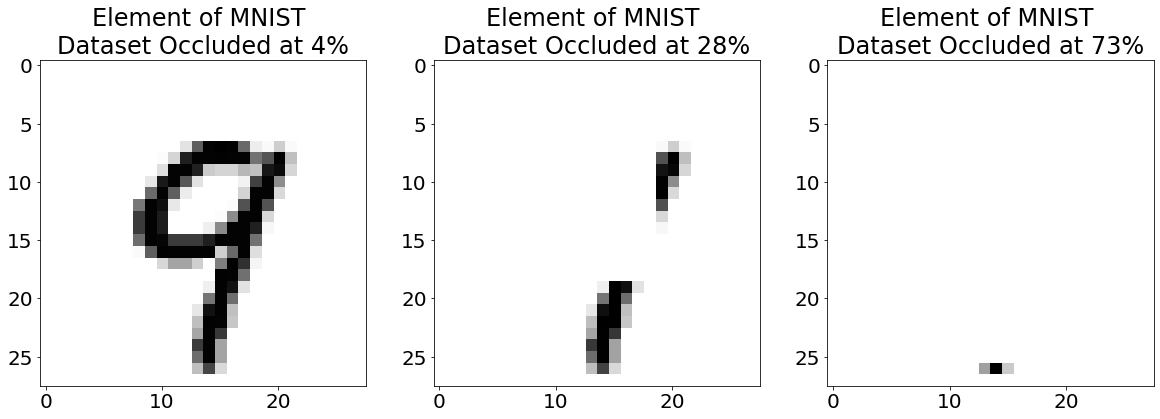

In [59]:
fig, ax = plt.subplots(1,3, figsize=(20,6))

for i,lenght in enumerate([6,15,24]):

    test_occluded_dataset,percentage = MNIST_occlusion(dataset = test_dataset,square_lenght=lenght)
    test_occluded_dataloader = DataLoader(test_occluded_dataset,batch_size=512)
    ax[i].imshow(np.reshape(test_occluded_dataset.data[12,:,:].cpu().numpy(), (28, 28)), cmap='Greys')
    ax[i].set_title('Element of MNIST \nDataset Occluded at '+str(int(percentage))+ "%",fontsize=24)
    ax[i].tick_params(labelsize=20)

plt.savefig('./plots/mnist_occluded.png',bbox_inches="tight")

In [60]:
side_lenghts = np.arange(start=6,stop=15,step=2)
test_loss_occlusion_list = []
percentage_list = []

for side in tqdm(side_lenghts):
    
    test_occluded_dataset, percentage = MNIST_occlusion(dataset=test_dataset,square_lenght=side)
    test_occluded_dataloader = DataLoader(test_occluded_dataset,batch_size=512)
    best_net2 = AEs.Autoencoder(encoded_space_dim=load_results_hidden[4][1],params_dict = best_combination).to(device)
    train_loss_log_occlusion,test_loss_log_occlusion,train_loss_occlusion,test_loss_occlusion = best_net2.trainin(train_dataloader=join_train_dataloader,
                        test_dataloader=test_occluded_dataloader,params_dict = best_combination,verbose = False,return_log=True)
    
    print("TEST LOSS BEST HP ON TEST SET WITH OCCLUSION "+str(int(percentage)) +"% :", round(float(test_loss_occlusion.numpy()),4))
    test_loss_occlusion_list.append(float(test_loss_occlusion.numpy()))
    percentage_list.append(percentage)

ordered_list_occlusion = list(zip(test_loss_occlusion_list,percentage_list))

 20%|████████████████▌                                                                  | 1/5 [14:00<56:03, 840.79s/it]

TEST LOSS BEST HP ON TEST SET WITH OCCLUSION 4% : 0.0187


 40%|█████████████████████████████████▏                                                 | 2/5 [28:00<42:01, 840.57s/it]

TEST LOSS BEST HP ON TEST SET WITH OCCLUSION 8% : 0.0291


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [41:59<28:00, 840.08s/it]

TEST LOSS BEST HP ON TEST SET WITH OCCLUSION 12% : 0.0305


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [55:59<13:59, 839.84s/it]

TEST LOSS BEST HP ON TEST SET WITH OCCLUSION 18% : 0.0389


100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [1:09:58<00:00, 839.65s/it]

TEST LOSS BEST HP ON TEST SET WITH OCCLUSION 25% : 0.047


In [61]:
with open('./results/train_results_occlusion.data', 'wb') as filehandle_occlusion:
    pickle.dump(ordered_list_occlusion, filehandle_occlusion)  

In [62]:
with open('./results/train_results_occlusion.data', "rb") as input_file_occlusion:
    load_results_occlusion = pickle.load(input_file_occlusion)

In [63]:
test_loss_occlusion = [load_results_occlusion[i][0] for i in range(len(load_results_occlusion))]
percentage_occlusion = [load_results_occlusion[i][1] for i in range(len(load_results_occlusion))]

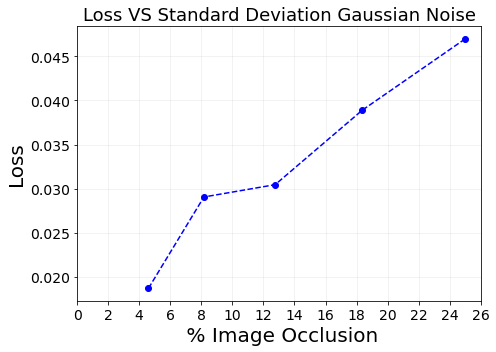

In [91]:
fig = plt.figure()
plt.plot(percentage_occlusion,test_loss_occlusion, label='Validation Loss',linestyle='--', marker='o', color='b')
plt.title('Loss VS Standard Deviation Gaussian Noise',fontsize=18)
plt.ylabel("Loss",fontsize=20)
plt.xlabel(" % Image Occlusion",fontsize=20)
plt.tick_params(labelsize=14)
fig.set_size_inches(7, 5)
plt.grid(alpha=0.2)
plt.xticks(range(0,28,2))
plt.tight_layout()
plt.savefig('./plots/loss_vs_percentage_occlusion.png',bbox_inches="tight")
plt.show()

## DENOISING AUTOENCODER

In [81]:
sigma = 0.5
gaussian_test_transform = transforms.Compose([
transforms.ToTensor(),
transforms.Lambda(lambda x: (x+np.random.normal(scale=sigma,size=x.shape)).float()),
])

join_train_dataloader = DataLoader(train_dataset0,batch_size=512,shuffle=False)

# load dataset and apply noise to it 
noised_train_dataset = MNIST(data_dir, train=True, download=False, transform=gaussian_test_transform)
noised_train_dataloader = DataLoader(noised_train_dataset, batch_size=512, shuffle=False)

noised_test_dataset = MNIST(data_dir, train=False, download=False, transform=gaussian_test_transform)
noised_test_dataloader = DataLoader(noised_test_dataset, batch_size=512, shuffle=False)

In [86]:
best_net_dae = AEs.Autoencoder(encoded_space_dim=load_results_hidden[4][1],params_dict = best_combination).to(device)
train_loss_log,test_loss_log,train_loss,test_loss = best_net_dae.dae_trainin(train_noise_dataloader=noised_train_dataloader,
                    train_orig_dataloader = join_train_dataloader, test_orig_dataloader=test_dataloader,test_noise_dataloader=noised_test_dataloader,params_dict = best_combination,verbose = False,return_log=True)
print("TEST LOSS BEST HP ON TEST SET WITH NOISE:", round(float(test_loss.numpy()),3))

TEST LOSS BEST HP ON TEST SET WITH NOISE: 0.026


In [87]:
torch.save(best_net_dae.state_dict(), './models/best_net_dae.pth')

In [88]:
best_net_dae_load = AEs.Autoencoder(encoded_space_dim=load_results_hidden[4][1],params_dict = best_combination).to(device)
best_net_dae_load.load_state_dict(torch.load('./models/best_net_dae.pth', map_location=device))
best_net_dae_load.to(device);

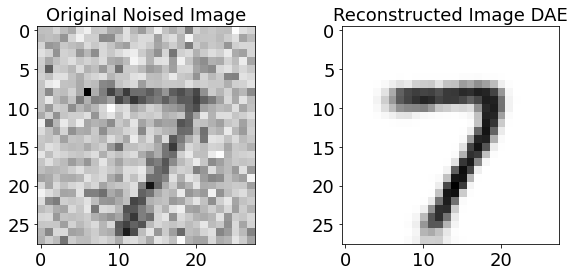

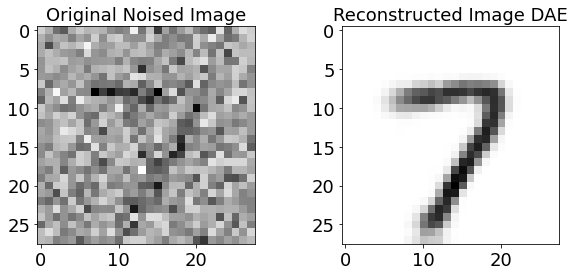

In [89]:
sigma_list = [0.3,0.7]
for sigma in sigma_list:
    gaussian_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x+np.random.normal(scale=sigma,size=x.shape)).float()),
    ])

    noised_test_dataset = MNIST(data_dir, train=False, download=False, transform=gaussian_test_transform)
    noised_test_dataloader = DataLoader(noised_test_dataset, batch_size=512, shuffle=False)

    best_net_dae_load.save_comparative_plot(sample_orig=test_dataloader, sample_noised=noised_test_dataloader,filename= "comparison_sigma" + str(sigma))

## GENERATIVE CAPABILITIES OF AUTOENCODER: SAMPLING FROM LATENT SPACE

Is the representational space of your autoencoder regular enough to allow for a smooth sampling?
(i.e., nearby points in the representational space produce similar

In [8]:
best_net_fixed_hidden = torch.load('./models/best_network.dat')

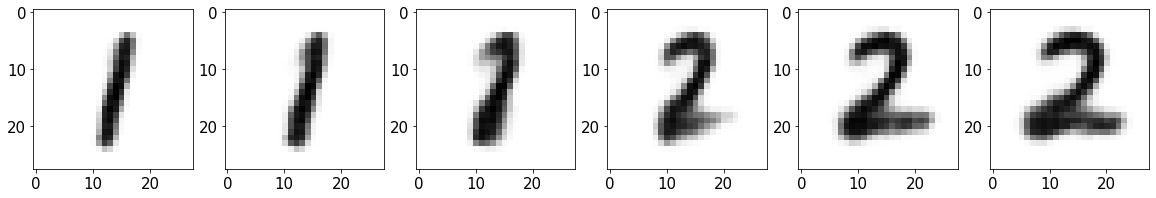

In [9]:
encoded_images = best_net_fixed_hidden.encode_rep(test_dataset)
best_net_fixed_hidden.images_smooth_sampling(encoded_images,start_digit=1,stop_digit=2, number_steps=6)